In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.units as u
import treecorr
from pathlib import Path

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [2]:
data_file = "../data/optic_shapes.fits"

out_dir = "../out/20230619_measured/"
plot_dir = "../figs/20230619_measured/"
Path(plot_dir).mkdir(parents=True, exist_ok=True)
Path(out_dir).mkdir(parents=True, exist_ok=True)

# Read in the data
with fits.open(data_file) as hdul:
    data = hdul[1].data
    print(hdul[1].columns)

ColDefs(
    name = 'x'; format = 'D'
    name = 'y'; format = 'D'
    name = 'w'; format = 'D'
    name = 'g1'; format = 'D'
    name = 'g2'; format = 'D'
)


In [4]:
len(data)

100000

In [5]:
gammas = data["g1"] + 1j*data["g2"]

def getLineParameters(xpos, ypos, gamma):
    length, angle = np.abs(gamma), np.angle(gamma)
    return [xpos - np.cos(angle)*length/2, xpos + np.cos(angle)*length/2], \
            [ypos - np.sin(angle)*length/2, ypos + np.sin(angle)*length/2]

conversion_factor = (1*u.arcsec/u.degree).to("").value
RA_vals, Dec_vals = data["x"] * conversion_factor, data["y"] * conversion_factor
coords = np.vstack((RA_vals, Dec_vals, gammas)).T
np.random.shuffle(coords)

/global/cfs/cdirs/des/shubh/.conda/envs/aber/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


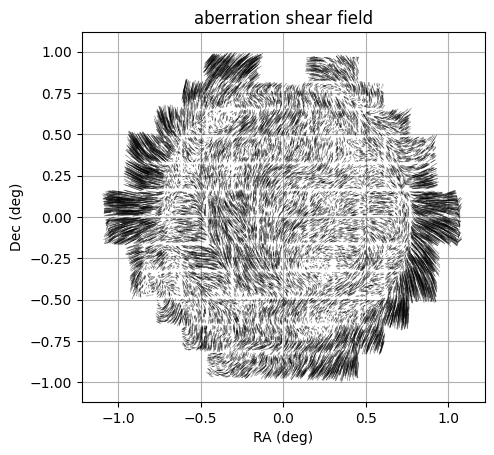

In [17]:
scaling_factor = 5
fig, ax = plt.subplots()
for ra, de, gam in coords[::5]:
    plt.plot(*getLineParameters(ra, de, gam*scaling_factor), \
                color="black", lw=0.5, alpha = 0.5)

# Show the plot
plot_margin = 0.15
ax.set_aspect('equal')
plt.xlim([np.nanmin(RA_vals) - plot_margin, np.nanmax(RA_vals) + plot_margin])
plt.ylim([np.nanmin(Dec_vals) - plot_margin, np.nanmax(Dec_vals) + plot_margin])
plt.grid()
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.title("aberration shear field")
plt.savefig(plot_dir + "aberration_shear_field.png", dpi=300)
plt.show()
plt.close()

In [7]:
cat = treecorr.Catalog(data_file, x_col='x', y_col='y', g1_col='g1', g2_col='g2',
                       x_units='arcsec', y_units='arcsec')
gg = treecorr.GGCorrelation(min_sep=1, max_sep=100, sep_units='arcmin', bin_size=0.1)
gg.process(cat)

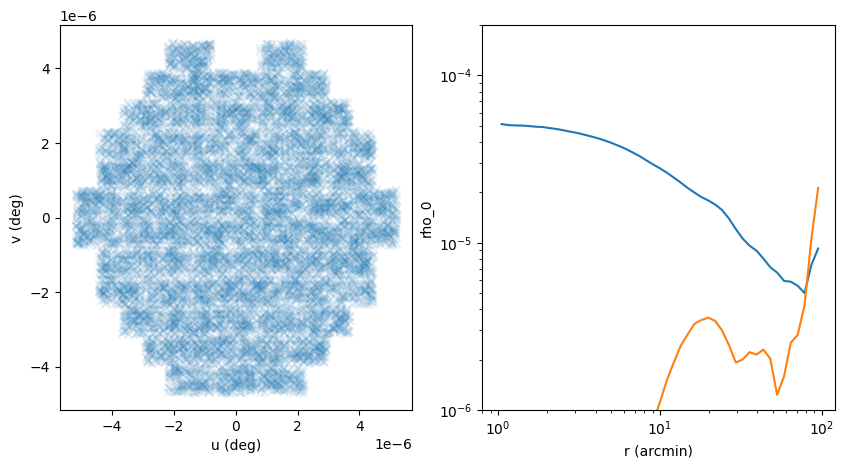

In [8]:
fix, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(cat.x[::10] * conversion_factor, cat.y[::10] * conversion_factor, \
              alpha=0.1, marker="x")
ax[0].set_xlabel('u (deg)')
ax[0].set_ylabel('v (deg)')

ax[1].plot(np.exp(gg.meanlogr), gg.xip)
ax[1].plot(np.exp(gg.meanlogr), gg.xim)
ax[1].set_xlabel('r (arcmin)')
ax[1].set_ylabel('rho_0')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylim(1.e-6, 2.e-4)
ax[1].set_xlim(0.8, 120)
plt.show()
plt.close()

In [9]:
rmin = 0.5
rmax = 20
nr = 10

cats = treecorr.Catalog(data_file, x_col='x', y_col='y', g1_col='g1', g2_col='g2',
                       x_units='arcsec', y_units='arcsec')

narrow = dict(min_sep=rmin, max_sep=rmax, sep_units='arcmin', nbins=nr,
              min_u=0.0, max_u=1, nubins=20,
              min_v=0.0, max_v=0.1, nvbins=1, verbose=2, output_dots=True)
wide = dict(min_sep=rmin, max_sep=rmax, sep_units='arcmin', nbins=nr,
            min_u=0.9, max_u=1, nubins=1,
            min_v=0.0, max_v=0.8, nvbins=20, verbose=2, output_dots=True)
wider = dict(min_sep=rmin, max_sep=rmax, sep_units='arcmin', nbins=nr,
             min_u=0.9, max_u=1, nubins=1,
             min_v=0.8, max_v=0.95, nvbins=20, verbose=2, output_dots=True)
widest = dict(min_sep=rmin, max_sep=rmax, sep_units='arcmin', nbins=nr,
              min_u=0.9, max_u=1, nubins=1,
              min_v=0.95, max_v=1.0, nvbins=20, verbose=2, output_dots=True)

In [10]:
print("narrow")
ggg1 = treecorr.GGGCorrelation(narrow)
try:
    ggg1.read(out_dir + 'narrow.hdf')
except:
    ggg1.process(cats, comm=comm)
    ggg1.write(out_dir + 'narrow.hdf', write_patch_results=True)

print("wide")
ggg2 = treecorr.GGGCorrelation(wide)
try:
    ggg2.read(out_dir + 'wide.hdf')
except:
    ggg2.process(cats, comm=comm)
    ggg2.write(out_dir + 'wide.hdf', write_patch_results=True)

print("wider")
ggg3 = treecorr.GGGCorrelation(wider)
try:
    ggg3.read(out_dir + 'wider.hdf')
except:
    ggg3.process(cats, comm=comm)
    ggg3.write(out_dir + 'wider.hdf', write_patch_results=True)

print("widest")
ggg4 = treecorr.GGGCorrelation(widest)
try:
    ggg4.read(out_dir + 'widest.hdf')
except:
    ggg4.process(cats, comm=comm)
    ggg4.write(out_dir + 'widest.hdf', write_patch_results=True)

narrow
r: nbins = 10, min,max sep = 0.5..20 arcmin, bin_size = 0.368888
u: nbins = 20, min,max = 0..1, bin_size = 0.05
v: nbins = 1, min,max = 0..0.1, bin_size = 0.1
Reading GGG correlations from ../out/20230619_measured/narrow.hdf
   file_type assumed to be HDF from the file name.
wide
r: nbins = 10, min,max sep = 0.5..20 arcmin, bin_size = 0.368888
u: nbins = 1, min,max = 0.9..1, bin_size = 0.1
v: nbins = 20, min,max = 0..0.8, bin_size = 0.04
Reading GGG correlations from ../out/20230619_measured/wide.hdf
   file_type assumed to be HDF from the file name.
wider
r: nbins = 10, min,max sep = 0.5..20 arcmin, bin_size = 0.368888
u: nbins = 1, min,max = 0.9..1, bin_size = 0.1
v: nbins = 20, min,max = 0.8..0.95, bin_size = 0.0075
Reading GGG correlations from ../out/20230619_measured/wider.hdf
   file_type assumed to be HDF from the file name.
widest
r: nbins = 10, min,max sep = 0.5..20 arcmin, bin_size = 0.368888
u: nbins = 1, min,max = 0.9..1, bin_size = 0.1
v: nbins = 20, min,max = 0.95

In [13]:
g_ttt_func = lambda ggg: -0.25 * (ggg.gam0 + ggg.gam1 + ggg.gam2 + ggg.gam3).real
g_txx_func = lambda ggg: -0.25 * (- ggg.gam0 - ggg.gam1 + ggg.gam2 + ggg.gam3).real
g_xtx_func = lambda ggg: -0.25 * (- ggg.gam0 + ggg.gam1 - ggg.gam2 + ggg.gam3).real
g_xxt_func = lambda ggg: -0.25 * (- ggg.gam0 + ggg.gam1 + ggg.gam2 - ggg.gam3).real
g_ttx_func = lambda ggg: 0.25 * (ggg.gam0 + ggg.gam1 + ggg.gam2 - ggg.gam3).imag
g_txt_func = lambda ggg: 0.25 * (ggg.gam0 + ggg.gam1 - ggg.gam2 + ggg.gam3).imag
g_xtt_func = lambda ggg: 0.25 * (ggg.gam0 - ggg.gam1 + ggg.gam2 + ggg.gam3).imag
g_xxx_func = lambda ggg: 0.25 * (- ggg.gam0 + ggg.gam1 + ggg.gam2 + ggg.gam3).imag

def var_func(ggg):
    return 0.25**2 * (ggg.vargam0 + ggg.vargam1 + ggg.vargam2 + ggg.vargam3)

def get_gamma_func(g_func, var_func):
    all_g_ttt = []
    all_sig_ttt = []
    all_meanr = []
    all_phi = []

    for ggg in [ggg1, ggg2, ggg3, ggg4]:

        g_ttt = g_func(ggg)
        var_ttt = var_func(ggg)

        _nr, nu, nv = g_ttt.shape
        assert _nr == nr
        assert nv % 2 == 0
        nv //= 2
        assert nu == 1 or nv == 1

        d1 = ggg.meand1
        d2 = ggg.meand2
        d3 = ggg.meand3
        if nu == 1:
            # if nu==1, then u=1, so d2 = d3, and phi is between d2 and d3
            phi = np.arccos( (d2**2 + d3**2 - d1**2) / (2*d2*d3) )
            meanr = np.array([np.mean([d2[ir], d3[ir]]) for ir in range(nr)])
        else:
            # if nv==1, then v=0, so d1 = d2, and phi is between d1 and d2
            phi = np.arccos( (d1**2 + d2**2 - d3**2) / (2*d1*d2) )
            meanr = np.array([np.mean([d1[ir], d2[ir]]) for ir in range(nr)])
        phi *= 180/np.pi

        # We don't care about v>0 vs v<0, so combine them.
        phi = (phi[:,:,nv-1::-1] + phi[:,:,nv:]) / 2
        g_ttt = (g_ttt[:,:,nv-1::-1] + g_ttt[:,:,nv:]) / 2
        var_ttt = (var_ttt[:,:,nv-1::-1] + var_ttt[:,:,nv:]) / 4
        sig_ttt = var_ttt**0.5

        # print('shapes:')
        # print('phi: ',phi.shape)
        # print('g_ttt: ',g_ttt.shape)
        # print('sig_ttt: ',sig_ttt.shape)
        # print('meanr: ',meanr.shape)

        # print('meanr =  ',meanr)

        if nu == 1:
            phi = phi[:,0,:]
            g_ttt = g_ttt[:,0,:]
            sig_ttt = sig_ttt[:,0,:]
        else:
            phi = phi[:,:,0]
            g_ttt = g_ttt[:,:,0]
            sig_ttt = sig_ttt[:,:,0]

        # print('shapes ->')
        # print('phi: ',phi.shape)
        # print('g_ttt: ',g_ttt.shape)
        # print('sig_ttt: ',sig_ttt.shape)

        all_phi.append(phi)
        all_g_ttt.append(g_ttt)
        all_sig_ttt.append(sig_ttt)
        all_meanr.append(meanr)

    phi = np.concatenate(all_phi, axis=1)
    g_ttt = np.concatenate(all_g_ttt, axis=1)
    sig_ttt = np.concatenate(all_sig_ttt, axis=1)
    meanr = np.concatenate(all_meanr, axis=0)
    
    return phi, g_ttt, sig_ttt, meanr

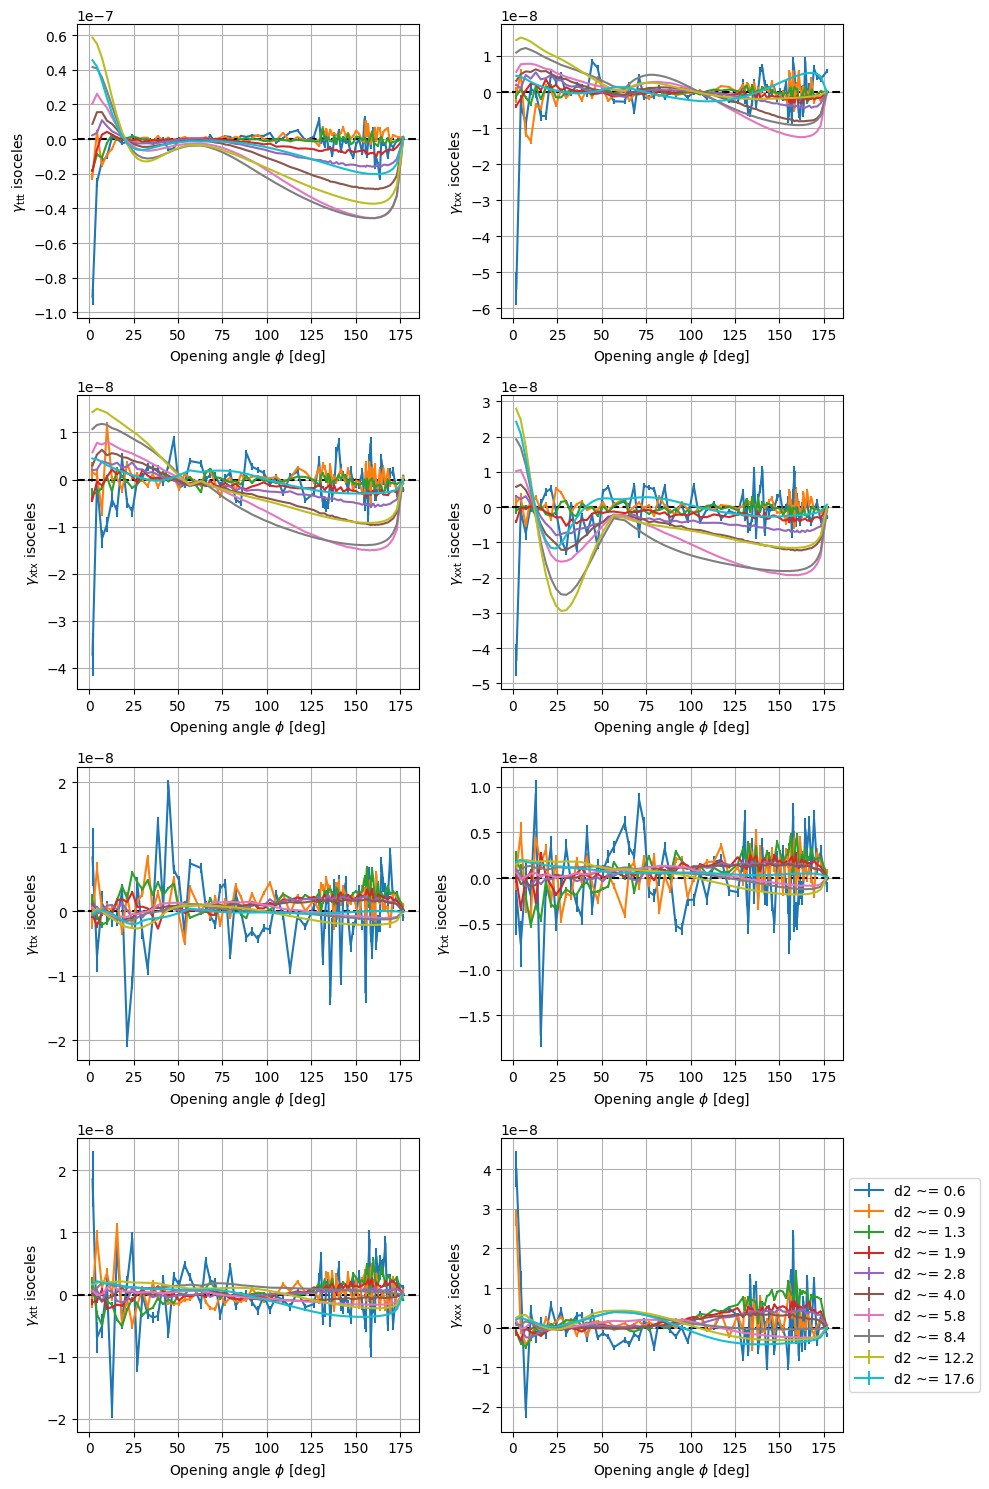

In [16]:
g_funcs = [g_ttt_func, g_txx_func, g_xtx_func, g_xxt_func, g_ttx_func, g_txt_func, g_xtt_func, g_xxx_func]
labels = ["{\\rm ttt}", "{\\rm txx}", "{\\rm xtx}", "{\\rm xxt}", "{\\rm ttx}", "{\\rm txt}", "{\\rm xtt}", "{\\rm xxx}"]

fig, axs = plt.subplots(4, 2, figsize=(10, 15))

for label, g_func, ax in zip(labels, g_funcs, axs.ravel()):
    
    phi, g_txx, sig_txx, meanr = get_gamma_func(g_func, var_func)
    lines = []
    for ir in range(nr):
        line = ax.errorbar(phi[ir], g_txx[ir], sig_txx[ir])
        lines.append((line, 'd2 ~= %.1f'%meanr[ir]))
    ax.set_xlabel(r'Opening angle $\phi$ [deg]')
    ax.set_ylabel(r'$\gamma_{}$ isoceles'.format(label))
    # ax.set_xlim([155, 180])
    fig.set_tight_layout(True)
    ax.grid()
    ax.axhline(y=0, ls="--", color="black")
plt.legend(*(list(zip(*lines))), loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(plot_dir + "3pt.png", dpi=300)
plt.show()
plt.close()